# Compose Complete DataFrame


# Predicting NFL Win Totals

## BASELINE

## constraints
- years: 2009-present
- all 32 teams


## Model
- Random Forest

## Dependent Variable
- Current Year's Win Total

## Independent Variables
- [x]  Previous Year's Strength of Schedule
- [x] Current Year's Market-Priced Strength of Schedule
- [ ] Previous Year's Relative Performance (EPA Standardized w.r.t Year)

In [1]:
# import python packages & libraries
import numpy as np
import pandas as pd
import nfl_data_py as nfl

In [2]:
# YEARS = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
YEARS = [2018,2019,2020]

# Get Data
- Previous Year's Strength of Schedule
    - Each opposing team's previous year's Win PCT
        - Obtain schedule for the `result` for `game_type` REG season (ref: data_dict https://github.com/nflverse/nflreadr/blob/main/data-raw/dictionary_schedules.csv)
        - Transform schedule result to win/loss
        - Group Year & Team to obtain sum of wins / count games played
- Current Year's Market-Priced Strength of Schedule
    - Each opposing team's expected Win PCT
- Previous Year's Relative Performance
    - Team's EPA standardized w.r.t Year's mean team EPA
    

## Previous Year's Strength of Schedule

In [3]:
# import the NFL schedule
nfl_schedule = nfl.import_schedules(years=YEARS)

In [4]:
nfl_wins = nfl_schedule.loc[nfl_schedule['game_type'] == 'REG',['game_id','season','game_type','home_team','away_team','result']]

In [5]:
nfl_wins = pd.melt(nfl_wins, id_vars=['game_id','season','game_type','result'], var_name=['home_away'], value_vars=['home_team', 'away_team'], value_name='team_name')

In [6]:
home_team_score_more = (nfl_wins.result > 0) & (nfl_wins.home_away == 'home_team')
away_team_score_more = (nfl_wins.result < 0) & (nfl_wins.home_away == 'away_team')
team_score_tie = (nfl_wins.result == 0)
home_win = 1
away_win = 1
tie = 0
conditions = [home_team_score_more, away_team_score_more, team_score_tie]
results = [home_win, away_win, tie]
nfl_wins['win'] = np.select(conditions, results, default=0)

In [7]:
home_team_score_less = (nfl_wins.result < 0) & (nfl_wins.home_away == 'home_team')
away_team_score_less = (nfl_wins.result > 0) & (nfl_wins.home_away == 'away_team')
team_score_tie = (nfl_wins.result == 0)
home_loss = 1
away_loss = 1
tie = 0
conditions = [home_team_score_less, away_team_score_less, team_score_tie]
results = [home_loss, away_loss, tie]
nfl_wins['loss'] = np.select(conditions, results, default=0)

In [8]:
home_team_score_less = (nfl_wins.result < 0) & (nfl_wins.home_away == 'home_team')
away_team_score_less = (nfl_wins.result > 0) & (nfl_wins.home_away == 'away_team')
team_score_tie = (nfl_wins.result == 0)
home_loss = 0
away_loss = 0
tie = 1
conditions = [home_team_score_less, away_team_score_less, team_score_tie]
results = [home_loss, away_loss, tie]
nfl_wins['tie'] = np.select(conditions, results, default=0)

In [9]:
nfl_records = nfl_wins.groupby(['team_name','season']).agg({'win':'sum', 'loss':'sum', 'tie':'sum'}).reset_index()
nfl_records

,team_name,season,win,loss,tie
0,ARI,2018,3,13,0
1,ARI,2019,5,10,1
2,ARI,2020,8,8,0
3,ATL,2018,7,9,0
4,ATL,2019,7,9,0
...,...,...,...,...,...
91,TEN,2019,9,7,0
92,TEN,2020,11,5,0
93,WAS,2018,7,9,0
94,WAS,2019,3,13,0


In [10]:
wins2 = nfl_wins.copy()

In [11]:
temp = wins2.groupby('game_id')['team_name'].agg(pd.Series.tolist).reset_index().rename(columns={'team_name':'game_teams'})
temp

,game_id,game_teams
0,2018_01_ATL_PHI,"[PHI, ATL]"
1,2018_01_BUF_BAL,"[BAL, BUF]"
2,2018_01_CHI_GB,"[GB, CHI]"
3,2018_01_CIN_IND,"[IND, CIN]"
4,2018_01_DAL_CAR,"[CAR, DAL]"
...,...,...
763,2020_17_NYJ_NE,"[NE, NYJ]"
764,2020_17_PIT_CLE,"[CLE, PIT]"
765,2020_17_SEA_SF,"[SF, SEA]"
766,2020_17_TEN_HOU,"[HOU, TEN]"


In [12]:
wins2 = pd.merge(wins2, temp, on='game_id')

In [13]:
match_team_name = (wins2.team_name == wins2.game_teams.str[0])
conditions = [match_team_name]
team2 = wins2.game_teams.str[1]
results = [team2]
wins2['opposing_team'] = np.select(conditions, results, default=wins2.game_teams.str[0])

In [14]:
wins2

,game_id,season,game_type,result,home_away,team_name,win,loss,tie,game_teams,opposing_team
0,2018_01_ATL_PHI,2018,REG,6.0,home_team,PHI,1,0,0,"[PHI, ATL]",ATL
1,2018_01_ATL_PHI,2018,REG,6.0,away_team,ATL,0,1,0,"[PHI, ATL]",PHI
2,2018_01_BUF_BAL,2018,REG,44.0,home_team,BAL,1,0,0,"[BAL, BUF]",BUF
3,2018_01_BUF_BAL,2018,REG,44.0,away_team,BUF,0,1,0,"[BAL, BUF]",BAL
4,2018_01_PIT_CLE,2018,REG,0.0,home_team,CLE,0,0,1,"[CLE, PIT]",PIT
...,...,...,...,...,...,...,...,...,...,...,...
1531,2020_17_ARI_LA,2020,REG,11.0,away_team,ARI,0,1,0,"[LA, ARI]",LA
1532,2020_17_SEA_SF,2020,REG,-3.0,home_team,SF,0,1,0,"[SF, SEA]",SEA
1533,2020_17_SEA_SF,2020,REG,-3.0,away_team,SEA,1,0,0,"[SF, SEA]",SF
1534,2020_17_WAS_PHI,2020,REG,-6.0,home_team,PHI,0,1,0,"[PHI, WAS]",WAS


In [15]:
# nfl_records['win_pct'] = nfl_records['win_pct'].round(3)
nfl_records['season_n'] = nfl_records['season'] +1
nfl_records.rename(columns={'season':'season_n-1','team_name':'matching_opposing_team_name','win':'season_n-1_win_total','loss':'season_n-1_loss_total', 'tie':'season_n-1_tie_total'}, inplace=True)
nfl_records['season_n-1_games_played'] = nfl_records[['season_n-1_win_total','season_n-1_loss_total','season_n-1_tie_total']].sum(axis=1)
nfl_records

,matching_opposing_team_name,season_n-1,season_n-1_win_total,season_n-1_loss_total,season_n-1_tie_total,season_n,season_n-1_games_played
0,ARI,2018,3,13,0,2019,16
1,ARI,2019,5,10,1,2020,16
2,ARI,2020,8,8,0,2021,16
3,ATL,2018,7,9,0,2019,16
4,ATL,2019,7,9,0,2020,16
...,...,...,...,...,...,...,...
91,TEN,2019,9,7,0,2020,16
92,TEN,2020,11,5,0,2021,16
93,WAS,2018,7,9,0,2019,16
94,WAS,2019,3,13,0,2020,16


In [16]:
# adjust for team's relocation: OAK -> LV
team_OAK = nfl_records['matching_opposing_team_name'] == 'OAK'
season_2019 = nfl_records['season_n-1'] == 2019
nfl_records.loc[((team_OAK)&(season_2019)),'matching_opposing_team_name'] = 'LV'

# adjust for team's relocation: SD -> LAC
team_SD = nfl_records['matching_opposing_team_name'] == 'SD'
season_2016 = nfl_records['season_n-1'] == 2016
nfl_records.loc[((team_SD)&(season_2016)),'matching_opposing_team_name'] = 'LAC'

# adjust for team's relocation: STL -> LA
team_STL = nfl_records['matching_opposing_team_name'] == 'STL'
season_2015 = nfl_records['season_n-1'] == 2015
nfl_records.loc[((team_STL)&(season_2015)),'matching_opposing_team_name'] = 'LA'


In [17]:
assert all(nfl_records.loc[(nfl_records['season_n-1'] < 2021),'season_n-1_games_played'] == 16), "Not all opposing_team season_n-1_games_played are accounted"
assert all(nfl_records.loc[(nfl_records['season_n-1'] >= 2021),'season_n-1_games_played'] == 17), "Not all opposing_team season_n-1_games_played are accounted"

In [18]:
nfl_records

,matching_opposing_team_name,season_n-1,season_n-1_win_total,season_n-1_loss_total,season_n-1_tie_total,season_n,season_n-1_games_played
0,ARI,2018,3,13,0,2019,16
1,ARI,2019,5,10,1,2020,16
2,ARI,2020,8,8,0,2021,16
3,ATL,2018,7,9,0,2019,16
4,ATL,2019,7,9,0,2020,16
...,...,...,...,...,...,...,...
91,TEN,2019,9,7,0,2020,16
92,TEN,2020,11,5,0,2021,16
93,WAS,2018,7,9,0,2019,16
94,WAS,2019,3,13,0,2020,16


In [19]:
win_pct = pd.merge(wins2, nfl_records, left_on=['season','opposing_team'], right_on=['season_n','matching_opposing_team_name'])

In [20]:
# win_pct.groupby(['season_n','team_name_x']).agg({'win_total':'sum','loss_total':'sum', 'tie_total':'sum'}).sum(axis=1).sort_values()
wins3 = win_pct.groupby(['season_n','team_name']).agg({'season_n-1_win_total':'sum','season_n-1_loss_total':'sum', 'season_n-1_tie_total':'sum', 'season_n-1_games_played':'sum'}).reset_index()

In [21]:
wins3.rename(columns= {'season_n-1_win_total':'season_n-1_opposing_win_total','season_n-1_loss_total':'season_n-1_opposing_loss_total','season_n-1_tie_total':'season_n-1_opposing_tie_total'},inplace=True)
wins3['season_n-1_opposing_win_pct'] = (wins3['season_n-1_opposing_win_total'] + 0.5*wins3['season_n-1_opposing_tie_total'] ) / wins3['season_n-1_games_played']

In [22]:
assert all(nfl_records.loc[(nfl_records['season_n-1'] < 2021),'season_n-1_games_played'] == 16), "Not all opposing_team season_n-1_games_played are accounted"
assert all(nfl_records.loc[(nfl_records['season_n-1'] >= 2021),'season_n-1_games_played'] == 17), "Not all opposing_team season_n-1_games_played are accounted"

In [23]:
wins3

,season_n,team_name,season_n-1_opposing_win_total,season_n-1_opposing_loss_total,season_n-1_opposing_tie_total,season_n-1_games_played,season_n-1_opposing_win_pct
0,2019,ARI,129,125,2,256,0.507812
1,2019,ATL,132,123,1,256,0.517578
2,2019,BAL,125,127,4,256,0.496094
3,2019,BUF,122,132,2,256,0.480469
4,2019,CAR,128,127,1,256,0.501953
...,...,...,...,...,...,...,...
59,2020,SEA,129,125,2,256,0.507812
60,2020,SF,134,120,2,256,0.527344
61,2020,TB,128,127,1,256,0.501953
62,2020,TEN,127,128,1,256,0.498047


## Current Year's Market-Priced Strength of Schedule

In [24]:
# Create for-loop to grab sportsoddshistory pages. 
#  add season YEAR to the DataFrame
#  concat the data to create a single DataFrame
#  adjust team_name

# import nfl schedule and 
# calculate opposing team's market-line of win pct

In [25]:
nfl_market_exp_wins = pd.DataFrame()

for year in YEARS:
    sportsoddshistory = pd.read_html(f'https://www.sportsoddshistory.com/nfl-win/?y={year}&sa=nfl&t=win&o=t')
    sportsoddshistory[0]['season_n'] = year
    nfl_market_exp_wins = pd.concat([nfl_market_exp_wins,sportsoddshistory[0]], ignore_index=True)

In [26]:
nfl_market_exp_wins.rename(columns={'Team':'full_name'},inplace=True)

In [27]:
full_team_names = nfl_market_exp_wins['full_name'].unique()

In [28]:
full_team_names

array(['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens',
       'Buffalo Bills', 'Carolina Panthers', 'Chicago Bears',
       'Cincinnati Bengals', 'Cleveland Browns', 'Dallas Cowboys',
       'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
       'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars',
       'Kansas City Chiefs', 'Los Angeles Chargers', 'Los Angeles Rams',
       'Miami Dolphins', 'Minnesota Vikings', 'New England Patriots',
       'New Orleans Saints', 'New York Giants', 'New York Jets',
       'Oakland Raiders', 'Philadelphia Eagles', 'Pittsburgh Steelers',
       'San Francisco 49ers', 'Seattle Seahawks', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'Washington Redskins', 'Las Vegas Raiders',
       'Washington Football Team'], dtype=object)

In [29]:

full_team_names = ['Arizona Cardinals',
                   'Atlanta Falcons',
                   'Baltimore Ravens',
                   'Buffalo Bills',
                   'Carolina Panthers',
                   'Chicago Bears',
                   'Cincinnati Bengals',
                   'Cleveland Browns',
                   'Dallas Cowboys',
                   'Denver Broncos',
                   'Detroit Lions',
                   'Green Bay Packers',
                   'Houston Texans',
                   'Indianapolis Colts',
                   'Jacksonville Jaguars',
                   'Kansas City Chiefs',
                   'Las Vegas Raiders',
                   'Los Angeles Chargers',
                   'Los Angeles Rams',
                   'Miami Dolphins',
                   'Minnesota Vikings',
                   'New England Patriots',
                   'New Orleans Saints',
                   'New York Giants',
                   'New York Jets',
                   'Oakland Raiders',
                   'Philadelphia Eagles',
                   'Pittsburgh Steelers',
                   'San Diego Chargers',
                   'San Francisco 49ers',
                   'Seattle Seahawks',
                   'St Louis Rams',
                   'Tampa Bay Buccaneers',
                   'Tennessee Titans',
                   'Washington Football Team',
                   'Washington Redskins']
team_abbr = ['ARI',
             'ATL',
             'BAL',       
             'BUF',
             'CAR',
             'CHI',
             'CIN',
             'CLE',
             'DAL',
             'DEN',
             'DET',
             'GB',
             'HOU',
             'IND',
             'JAX',
             'KC',
             'LV',
             'LAC',
             'LA',
             'MIA',
             'MIN',
             'NE',
             'NO',
             'NYG',
             'NYJ',
             'OAK',
             'PHI',
             'PIT',
             'SD',
             'SF',
             'SEA',
             'STL',
             'TB', 
             'TEN',
             'WAS',
             'WAS'
             
]

# print(len(team_abbr) )
# print(len(full_team_names))
teams_df = pd.DataFrame({'full_name':full_team_names,'team_name':team_abbr})


In [30]:
nfl_market_exp_wins = pd.merge(nfl_market_exp_wins, teams_df, how='left')

In [31]:
nfl_market_exp_wins['full_name'].unique()

array(['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens',
       'Buffalo Bills', 'Carolina Panthers', 'Chicago Bears',
       'Cincinnati Bengals', 'Cleveland Browns', 'Dallas Cowboys',
       'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
       'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars',
       'Kansas City Chiefs', 'Los Angeles Chargers', 'Los Angeles Rams',
       'Miami Dolphins', 'Minnesota Vikings', 'New England Patriots',
       'New Orleans Saints', 'New York Giants', 'New York Jets',
       'Oakland Raiders', 'Philadelphia Eagles', 'Pittsburgh Steelers',
       'San Francisco 49ers', 'Seattle Seahawks', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'Washington Redskins', 'Las Vegas Raiders',
       'Washington Football Team'], dtype=object)

In [32]:
assert len(nfl_market_exp_wins[nfl_market_exp_wins['team_name'].isna()]) == 0

In [33]:
nfl_market_exp_wins.rename(columns={'Win Total':'exp_wins'}, inplace=True)
nfl_market_exp_wins

,full_name,exp_wins,Over Odds,Under Odds,Week betsettled,ActualWins,Result,season_n,team_name
0,Arizona Cardinals,6.0,-130,110,Week 15,3,Under,2018,ARI
1,Atlanta Falcons,9.5,-120,100,Week 12,7,Under,2018,ATL
2,Baltimore Ravens,8.5,-120,100,Week 16,10,Over,2018,BAL
3,Buffalo Bills,5.5,120,-140,Week 17,6,Over,2018,BUF
4,Carolina Panthers,8.5,110,-130,Week 15,7,Under,2018,CAR
...,...,...,...,...,...,...,...,...,...
91,San Francisco 49ers,10.5,120,-140,Week 10,6,Under,2020,SF
92,Seattle Seahawks,9.5,100,-120,Week 15,12,Over,2020,SEA
93,Tampa Bay Buccaneers,9.5,-125,105,Week 16,11,Over,2020,TB
94,Tennessee Titans,8.5,-130,110,Week 14,11,Over,2020,TEN


## Previous Year's Relative Performance

In [34]:
# import the NFL schedule
nfl_pbp = nfl.import_pbp_data(years=YEARS)

In [75]:
nfl_pbp.posteam.unique()

array([None, 'ATL', 'PHI', 'BAL', 'BUF', 'GB', 'CHI', 'CIN', 'IND', 'DAL',
       'CAR', 'NE', 'HOU', 'JAX', 'NYG', 'LAC', 'KC', 'LV', 'LA', 'NYJ',
       'DET', 'PIT', 'CLE', 'DEN', 'SEA', 'MIN', 'SF', 'NO', 'TB', 'TEN',
       'MIA', 'WAS', 'ARI'], dtype=object)

In [35]:
# sum the offensive epa and the defensive epa of each team in each season
nfl_epa = (nfl_pbp.groupby(['posteam','season'])['epa'].sum() + nfl_pbp.groupby(['defteam','season'])['epa'].sum() * -1).reset_index().sort_values('epa')


In [36]:
nfl_epa['epa'] = (nfl_epa['epa'] - nfl_epa['epa'].mean()) / nfl_epa['epa'].std()

In [37]:
nfl_epa.rename(columns={'posteam':'team_name','season':'season_n-1','epa':'season_n-1_epa' }, inplace=True)

In [38]:
nfl_epa['season_n'] = nfl_epa['season_n-1'] + 1

In [39]:
nfl_epa

,team_name,season_n-1,season_n-1_epa,season_n
74,NYJ,2020,-2.067600,2021
0,ARI,2018,-1.922276,2019
58,MIA,2019,-1.869190,2020
44,JAX,2020,-1.820533,2021
54,LV,2018,-1.678830,2019
...,...,...,...,...
46,KC,2019,1.789864,2020
64,NE,2019,1.827958,2020
89,TB,2020,1.831313,2021
85,SF,2019,1.888260,2020


<AxesSubplot:ylabel='Density'>

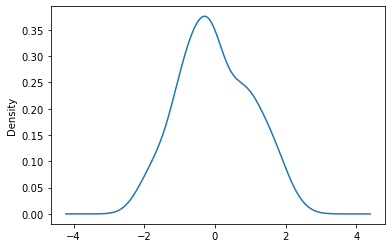

In [40]:
nfl_epa['season_n-1_epa'].plot.kde()

# Compose Complete DataFrame


In [41]:
wins3

,season_n,team_name,season_n-1_opposing_win_total,season_n-1_opposing_loss_total,season_n-1_opposing_tie_total,season_n-1_games_played,season_n-1_opposing_win_pct
0,2019,ARI,129,125,2,256,0.507812
1,2019,ATL,132,123,1,256,0.517578
2,2019,BAL,125,127,4,256,0.496094
3,2019,BUF,122,132,2,256,0.480469
4,2019,CAR,128,127,1,256,0.501953
...,...,...,...,...,...,...,...
59,2020,SEA,129,125,2,256,0.507812
60,2020,SF,134,120,2,256,0.527344
61,2020,TB,128,127,1,256,0.501953
62,2020,TEN,127,128,1,256,0.498047


In [42]:
wins2

,game_id,season,game_type,result,home_away,team_name,win,loss,tie,game_teams,opposing_team
0,2018_01_ATL_PHI,2018,REG,6.0,home_team,PHI,1,0,0,"[PHI, ATL]",ATL
1,2018_01_ATL_PHI,2018,REG,6.0,away_team,ATL,0,1,0,"[PHI, ATL]",PHI
2,2018_01_BUF_BAL,2018,REG,44.0,home_team,BAL,1,0,0,"[BAL, BUF]",BUF
3,2018_01_BUF_BAL,2018,REG,44.0,away_team,BUF,0,1,0,"[BAL, BUF]",BAL
4,2018_01_PIT_CLE,2018,REG,0.0,home_team,CLE,0,0,1,"[CLE, PIT]",PIT
...,...,...,...,...,...,...,...,...,...,...,...
1531,2020_17_ARI_LA,2020,REG,11.0,away_team,ARI,0,1,0,"[LA, ARI]",LA
1532,2020_17_SEA_SF,2020,REG,-3.0,home_team,SF,0,1,0,"[SF, SEA]",SEA
1533,2020_17_SEA_SF,2020,REG,-3.0,away_team,SEA,1,0,0,"[SF, SEA]",SF
1534,2020_17_WAS_PHI,2020,REG,-6.0,home_team,PHI,0,1,0,"[PHI, WAS]",WAS


In [43]:
nfl_epa

,team_name,season_n-1,season_n-1_epa,season_n
74,NYJ,2020,-2.067600,2021
0,ARI,2018,-1.922276,2019
58,MIA,2019,-1.869190,2020
44,JAX,2020,-1.820533,2021
54,LV,2018,-1.678830,2019
...,...,...,...,...
46,KC,2019,1.789864,2020
64,NE,2019,1.827958,2020
89,TB,2020,1.831313,2021
85,SF,2019,1.888260,2020


In [44]:
nfl_market_exp_wins

,full_name,exp_wins,Over Odds,Under Odds,Week betsettled,ActualWins,Result,season_n,team_name
0,Arizona Cardinals,6.0,-130,110,Week 15,3,Under,2018,ARI
1,Atlanta Falcons,9.5,-120,100,Week 12,7,Under,2018,ATL
2,Baltimore Ravens,8.5,-120,100,Week 16,10,Over,2018,BAL
3,Buffalo Bills,5.5,120,-140,Week 17,6,Over,2018,BUF
4,Carolina Panthers,8.5,110,-130,Week 15,7,Under,2018,CAR
...,...,...,...,...,...,...,...,...,...
91,San Francisco 49ers,10.5,120,-140,Week 10,6,Under,2020,SF
92,Seattle Seahawks,9.5,100,-120,Week 15,12,Over,2020,SEA
93,Tampa Bay Buccaneers,9.5,-125,105,Week 16,11,Over,2020,TB
94,Tennessee Titans,8.5,-130,110,Week 14,11,Over,2020,TEN


In [45]:
# adjust for team's relocation: OAK -> LV
team_OAK = nfl_epa['team_name'] == 'LV'
season_2019 = nfl_epa['season_n-1'] < 2019
nfl_epa.loc[((team_OAK)&(season_2019)),'team_name'] = 'OAK'

# adjust for team's relocation: SD -> LAC
team_SD = nfl_epa['team_name'] == 'SD'
season_2016 = nfl_epa['season_n-1'] < 2016
nfl_epa.loc[((team_SD)&(season_2016)),'team_name'] = 'LAC'

# adjust for team's relocation: STL -> LA
team_STL = nfl_epa['team_name'] == 'LA'
season_2015 = nfl_epa['season_n-1'] < 2015
nfl_epa.loc[((team_STL)&(season_2015)),'team_name'] = 'STL'

# merge previous seasons's epa to the team of the current season
wins3_epa = pd.merge(wins3, nfl_epa, on=['team_name', 'season_n'])
wins3_epa

,season_n,team_name,season_n-1_opposing_win_total,season_n-1_opposing_loss_total,season_n-1_opposing_tie_total,season_n-1_games_played,season_n-1_opposing_win_pct,season_n-1,season_n-1_epa
0,2019,ARI,129,125,2,256,0.507812,2018,-1.922276
1,2019,ATL,132,123,1,256,0.517578,2018,-0.108705
2,2019,BAL,125,127,4,256,0.496094,2018,0.931702
3,2019,BUF,122,132,2,256,0.480469,2018,-0.948269
4,2019,CAR,128,127,1,256,0.501953,2018,-0.051746
...,...,...,...,...,...,...,...,...,...
58,2020,SEA,129,125,2,256,0.507812,2019,0.113863
59,2020,SF,134,120,2,256,0.527344,2019,1.888260
60,2020,TB,128,127,1,256,0.501953,2019,0.102922
61,2020,TEN,127,128,1,256,0.498047,2019,0.792385


In [46]:
# merge current season's exp wins to the opposing team of the current season
# aggregate exp wins similar to season_n-1 win totals
nfl_market_exp_wins.rename(columns={'team_name':'opposing_team'}, inplace=True)
wins2.rename(columns={'season':'season_n'}, inplace=True)
wins2_market_exp_wins = pd.merge(wins2, nfl_market_exp_wins, on=['season_n', 'opposing_team'])
wins2_market_exp_wins

,game_id,season_n,game_type,result,home_away,team_name,win,loss,tie,game_teams,opposing_team,full_name,exp_wins,Over Odds,Under Odds,Week betsettled,ActualWins,Result
0,2018_01_ATL_PHI,2018,REG,6.0,home_team,PHI,1,0,0,"[PHI, ATL]",ATL,Atlanta Falcons,9.5,-120,100,Week 12,7,Under
1,2018_02_CAR_ATL,2018,REG,7.0,away_team,CAR,0,1,0,"[ATL, CAR]",ATL,Atlanta Falcons,9.5,-120,100,Week 12,7,Under
2,2018_03_NO_ATL,2018,REG,-6.0,away_team,NO,1,0,0,"[ATL, NO]",ATL,Atlanta Falcons,9.5,-120,100,Week 12,7,Under
3,2018_04_CIN_ATL,2018,REG,-1.0,away_team,CIN,1,0,0,"[ATL, CIN]",ATL,Atlanta Falcons,9.5,-120,100,Week 12,7,Under
4,2018_05_ATL_PIT,2018,REG,24.0,home_team,PIT,1,0,0,"[PIT, ATL]",ATL,Atlanta Falcons,9.5,-120,100,Week 12,7,Under
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,2020_13_DEN_KC,2020,REG,6.0,home_team,KC,1,0,0,"[KC, DEN]",DEN,Denver Broncos,7.5,-130,110,Week 15,5,Under
1532,2020_14_DEN_CAR,2020,REG,-5.0,home_team,CAR,0,1,0,"[CAR, DEN]",DEN,Denver Broncos,7.5,-130,110,Week 15,5,Under
1533,2020_15_BUF_DEN,2020,REG,-29.0,away_team,BUF,1,0,0,"[DEN, BUF]",DEN,Denver Broncos,7.5,-130,110,Week 15,5,Under
1534,2020_16_DEN_LAC,2020,REG,3.0,home_team,LAC,1,0,0,"[LAC, DEN]",DEN,Denver Broncos,7.5,-130,110,Week 15,5,Under


In [47]:
wins4 = wins2_market_exp_wins.groupby(['season_n','team_name']).agg({'exp_wins':'sum', 'game_teams':'count'}).reset_index()

In [48]:
wins4

,season_n,team_name,exp_wins,game_teams
0,2018,ARI,136.0,16
1,2018,ATL,130.0,16
2,2018,BAL,127.0,16
3,2018,BUF,133.0,16
4,2018,CAR,131.0,16
...,...,...,...,...
91,2020,SEA,131.0,16
92,2020,SF,131.5,16
93,2020,TB,129.0,16
94,2020,TEN,127.0,16


In [49]:
wins4.rename(columns= {'exp_wins':'season_n_opposing_exp_wins', 'game_teams':'season_n_games'},inplace=True)
wins4['season_n_opposing_exp_win_pct'] = wins4['season_n_opposing_exp_wins'] / (wins4['season_n_games'] * wins4['season_n_games'])

In [50]:
wins4

,season_n,team_name,season_n_opposing_exp_wins,season_n_games,season_n_opposing_exp_win_pct
0,2018,ARI,136.0,16,0.531250
1,2018,ATL,130.0,16,0.507812
2,2018,BAL,127.0,16,0.496094
3,2018,BUF,133.0,16,0.519531
4,2018,CAR,131.0,16,0.511719
...,...,...,...,...,...
91,2020,SEA,131.0,16,0.511719
92,2020,SF,131.5,16,0.513672
93,2020,TB,129.0,16,0.503906
94,2020,TEN,127.0,16,0.496094


In [51]:
combined_df = pd.merge(wins3_epa, wins4, on=['team_name', 'season_n'])

In [52]:
cols = ['season_n', 'team_name','season_n-1_epa', 'season_n-1_opposing_win_pct','season_n_opposing_exp_win_pct']
combined_df[cols]

,season_n,team_name,season_n-1_epa,season_n-1_opposing_win_pct,season_n_opposing_exp_win_pct
0,2019,ARI,-1.922276,0.507812,0.523438
1,2019,ATL,-0.108705,0.517578,0.521484
2,2019,BAL,0.931702,0.496094,0.511719
3,2019,BUF,-0.948269,0.480469,0.492188
4,2019,CAR,-0.051746,0.501953,0.509766
...,...,...,...,...,...
58,2020,SEA,0.113863,0.507812,0.511719
59,2020,SF,1.888260,0.527344,0.513672
60,2020,TB,0.102922,0.501953,0.503906
61,2020,TEN,0.792385,0.498047,0.496094
